In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

np.random.RandomState(42)

RandomState(MT19937) at 0x1A45597360

In [2]:
data = pd.read_stata('COVID.dta')

In [3]:
data.set_index('StateName', inplace=True)

In [4]:
data['Lockdown'] = 1 - data['Strategy']
data['CasesPerCap'] = data['Cases']/(data['Population'])
data['Intercept'] = 1

In [5]:
data.head()

,Population,Density,Age,Income,POC,Strategy,Cases,Deaths,Governor,Lockdown,CasesPerCap,Intercept
StateName,,,,,,,,,,,,
Alabama,4.9,93.500000,39.900002,48.099998,31.500000,0.0,4241.0,123.0,0.0,1.0,865.510193,1
Alaska,1.3,1.300000,34.000000,73.000000,33.299999,0.0,293.0,9.0,0.0,1.0,225.384628,1
Arizona,7.3,57.000000,37.400002,56.599998,27.000000,0.0,3692.0,142.0,0.0,1.0,505.753418,1
Arkansas,3.0,56.400002,37.900002,45.900002,23.000000,1.0,1599.0,34.0,0.0,0.0,533.000000,1
California,39.5,253.600006,36.299999,71.199997,27.900000,0.0,26838.0,864.0,1.0,1.0,679.443054,1


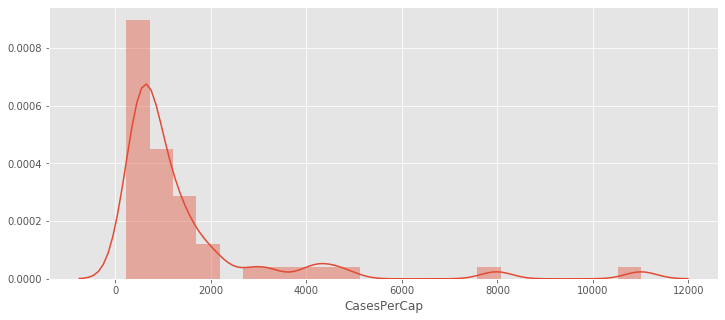

In [6]:
f, ax1 = plt.subplots(1, 1,
                       figsize=(12, 5),
)

sns.distplot(data['CasesPerCap'], ax=ax1)

### Model 1: Predict the Strategy

In [7]:
X = data[['Population', 'Density', 'Age', 'Income', 'POC', 'Governor']].copy()
y = data['Lockdown']

lr = Pipeline(
    steps = [('scale', StandardScaler()),
             ('smote', SMOTE()),
             ('clf', CalibratedClassifierCV(LogisticRegression()))
            ]   
)

lr.fit(X, y)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('smote',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=None,
                       sampling_strategy='auto')),
                ('clf',
                 CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0,
                                                                          class_weight=None,
                                                                          dual=False,
                                                                          fit_intercept=True,
                                                                          intercept_scaling=1,
                                                                          l1_ratio=None,
                                                                          max_iter=100,
                                                                          multi

In [8]:
propensity = pd.DataFrame(lr.predict_proba(X), index=data.index)
propensity.sort_values(by=1)

,0,1
StateName,,
Utah,0.885211,0.114789
Idaho,0.829723,0.170277
Wyoming,0.787564,0.212436
Nebraska,0.780540,0.219460
North Dakota,0.777525,0.222475
Alaska,0.731256,0.268744
South Dakota,0.713944,0.286056
Iowa,0.694327,0.305673
Arkansas,0.691609,0.308391


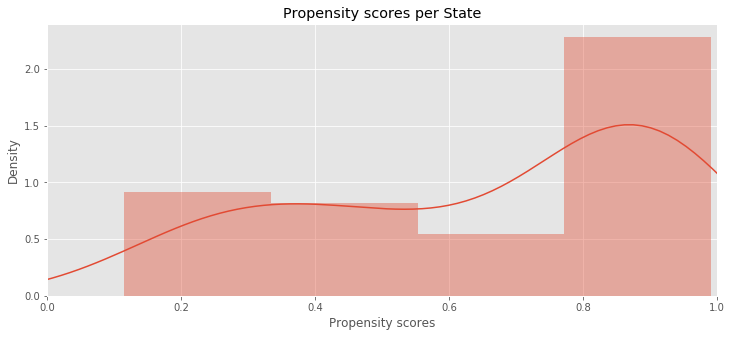

In [9]:
f, ax1 = plt.subplots(1, 1,
                       figsize=(12, 5),
)

sns.distplot(propensity[1], ax=ax1)
ax1.set_xlim(0, 1)
ax1.set_title("Propensity scores per State")
ax1.set_xlabel("Propensity scores")
ax1.set_ylabel('Density');

### Model 2: Use the Strategy probabilities as weights in a subsequent regression

In [10]:
data['Iptw'] =  1./ propensity.lookup(data.index, data['Strategy'])

In [11]:
X = data[['Population', 'Density', 'Age', 'Income', 'POC', 'Lockdown', 'Governor', 'Intercept']].copy()
y = data['CasesPerCap']

glm = sm.GLM(y, X, 
             family=sm.families.NegativeBinomial(),
             freq_weights=data['Iptw'])
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            CasesPerCap   No. Observations:                   50
Model:                            GLM   Df Residuals:                   535.02
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4704.4
Date:                Thu, 23 Apr 2020   Deviance:                       326.75
Time:                        19:51:48   Pearson chi2:                     497.
No. Iterations:                    16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population    -0.0015      0.004     -0.344      0.731      -0.010       0.007
Density        0.0027      0.000     15.224      0.000       0.002       0.003
Age            0.0133      0.031      0.427      0.670      -0.048       0.074
Income        -0.0522      0.007     -7.409      0.000      -0.066      -0.038
POC            0.0088      0.004      2.428      0.015       0.002       0.016
Lockdown      -0.3632      0.260     -1.396      0.163      -0.873       0.147
Governor       0.7309      0.141      5.170      0.000       0.454       1.008
Intercept      9.0590      1.300      6.970      0.000       6.512      11.606
==============================================================================
"""

We are modelling 

$$ \log{CasesPerCap} = \beta_0 + \beta_{Lockdown}*X_{Lockdown} + \beta_{Density}*X_{Density} + \beta_{Age}*X_{age} + \beta_{Income}*X_{Income} + \beta_{POC}*X_{POC} + + \beta_{Governor}*X_{Governor} $$

which means conditional on all other covariates being the same, when a state has lockdown the mean number of Cases per Capita decreases by:

$$ \log{Y_1} - \log{Y_0} = \log{\frac{Y_1}{Y_0}} \sim -0.36 $$

Where 


$$ Y_1 = \mathrm{CasesPerCap}, X_{Lockdown = 1} $$

and Y_0 is defined similarly.

Which means, that keeping all other covariates the same, imposing a lockdown caused about 36% fewer cases per capita, and this has an 16% chance of happening by random.

Given the small sample size this is probably the best p-value we will get.